## Import the Lib and Dependencies

In [1]:
import numpy as np
import math
from typing import List
import os
import argparse
import glob
import shutil
from torchvision import transforms
import torchvision.datasets as datasets
import torch.utils.data as loader
from torchvision import models
import torch
import torch.nn as nn
import time
import torch.optim as optim
from PIL import Image
import requests
import matplotlib.pyplot as plt
import boto3

import cv2
from random import shuffle

import sklearn
from sklearn.metrics import accuracy_score, cohen_kappa_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import copy
import tqdm.notebook as tqdm

import itertools

from torch.autograd import Variable

In [2]:
import sagemaker

sess = sagemaker.Session()

bucket = sess.default_bucket()
prefix = "sagemaker/DEMO-cv-covid"

print("The default s3 bucket is : "+ bucket)
print("The prefix of the folder is : "+ prefix)

client = boto3.client('s3')
client.put_object(Bucket = bucket, Key=prefix+'/')

The default s3 bucket is : sagemaker-ap-southeast-1-903419356784
The prefix of the folder is : sagemaker/DEMO-cv-covid


{'ResponseMetadata': {'RequestId': 'AS5G7DSW40Z2TTSW',
  'HostId': 'CvfTDAEFaygGGF/QHc877vLApXQ6wUZDysAyw4w8rb36kZiJLhaV+we5wFRET5qU78b1hA7jehY=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'CvfTDAEFaygGGF/QHc877vLApXQ6wUZDysAyw4w8rb36kZiJLhaV+we5wFRET5qU78b1hA7jehY=',
   'x-amz-request-id': 'AS5G7DSW40Z2TTSW',
   'date': 'Mon, 15 Nov 2021 11:39:48 GMT',
   'etag': '"d41d8cd98f00b204e9800998ecf8427e"',
   'server': 'AmazonS3',
   'content-length': '0'},
  'RetryAttempts': 0},
 'ETag': '"d41d8cd98f00b204e9800998ecf8427e"'}

### Download the COVID Xray Dataset

1. Download the Xray dataset from Kaggle : https://www.kaggle.com/pranavraikokte/covid19-image-dataset

2. Unzip the file

3. Upload the **Covid19-dataset** to S3 bucket (Into the bucket and folder that show above)



### Acknolwdegement

_The University of Montreal for releasing the images. 
It was collected from publicly released GitHub account by the University of Montreal professors. The Pneumonia data has been taken from the RSNA website._

### Download the Dataset from S3 to Local Directory

In [3]:
s3 = boto3.resource('s3') # assumes credentials & configuration are handled outside python in .aws directory or environment variables

def download_s3_folder(bucket_name, s3_folder, local_dir=None):
    """
    Download the contents of a folder directory
    Args:
        bucket_name: the name of the s3 bucket
        s3_folder: the folder path in the s3 bucket
        local_dir: a relative or absolute directory path in the local file system
    """
    bucket = s3.Bucket(bucket_name)
    for obj in bucket.objects.filter(Prefix=s3_folder):
        target = obj.key if local_dir is None \
            else os.path.join(local_dir, os.path.relpath(obj.key, s3_folder))
        if not os.path.exists(os.path.dirname(target)):
            os.makedirs(os.path.dirname(target))
        if obj.key[-1] == '/':
            continue
        bucket.download_file(obj.key, target)
        

In [4]:
download_s3_folder(bucket,prefix)

### Check the distribution

Let's have a look of the total images in the local path

In [5]:
!ls -1 "./sagemaker/DEMO-cv-covid/Covid19-dataset/train/Covid"| wc -l 
!ls -1 "./sagemaker/DEMO-cv-covid/Covid19-dataset/train/Normal"| wc -l 
!ls -1 "./sagemaker/DEMO-cv-covid/Covid19-dataset/train/Viral Pneumonia"| wc -l 

!ls -1 "./sagemaker/DEMO-cv-covid/Covid19-dataset/test/Covid"| wc -l 
!ls -1 "./sagemaker/DEMO-cv-covid/Covid19-dataset/test/Normal"| wc -l 
!ls -1 "./sagemaker/DEMO-cv-covid/Covid19-dataset/test/Viral Pneumonia"| wc -l 

111
70
70
26
20
20


### Reallocate the dataset

The downloaded dataset did not come with validation data set. Let's allocate 15% of the training data set to validation dataset


In [6]:

# Get all files in the current directory
def list_files(path):
    files = os.listdir(path)
    return np.asarray(files)

def split_files(oldpath, newpath, classes):
    for name in classes:
        full_dir = os.path.join(os.getcwd(), f"{oldpath}/{name}")

        files = list_files(full_dir)
        total_file = np.size(files,0)
        
        # We split training data set into 2: 80% of train and 20% of validation
        
        train_size = math.ceil(total_file * 4/5) # 80% for training 

        validation_size = train_size + math.ceil(total_file * 1/5) # 20% for validation
        
        
        train = files[0:train_size]
        validation = files[train_size:]

        move_files(train, full_dir, f"sagemaker/DEMO-cv-covid/Covid19-dataset/training/{name}")
        move_files(validation, full_dir, f"sagemaker/DEMO-cv-covid/Covid19-dataset/validation/{name}")


def move_files(files, old_dir, new_dir):
    new_dir = os.path.join(os.getcwd(), new_dir);
    if not os.path.exists(new_dir):
        os.makedirs(new_dir)

    for file in np.nditer(files):
        old_file_path = os.path.join(os.getcwd(), f"{old_dir}/{file}")
        new_file_path = os.path.join(os.getcwd(), f"{new_dir}/{file}")

        shutil.move(old_file_path, new_file_path)



### Execute spliting the file to training and validation

In [7]:
newpath ='./'
classes = ['Covid', 'Normal', 'Viral Pneumonia'];

split_files('./sagemaker/DEMO-cv-covid/Covid19-dataset/train', './', classes)

### Let's look at distribution of the training dataset

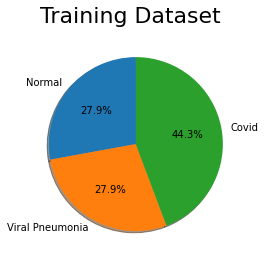

In [8]:
DATA_PATH = './sagemaker/DEMO-cv-covid/Covid19-dataset/training/'
class_names = os.listdir(DATA_PATH)
image_count = {}
for i in class_names:
    image_count[i] = len(os.listdir(os.path.join(DATA_PATH,i)))

#Plotting Distribution of Each Classes
fig1, ax1 = plt.subplots()
fig1.suptitle("Training Dataset", size=22)
ax1.pie(image_count.values(),
        labels = image_count.keys(),
        shadow=True,
        autopct = '%1.1f%%',
        startangle=90)
plt.show()

### Lets view some images to know what we are dealing with here. Feel free the run the cell below to view images at random from the repository.

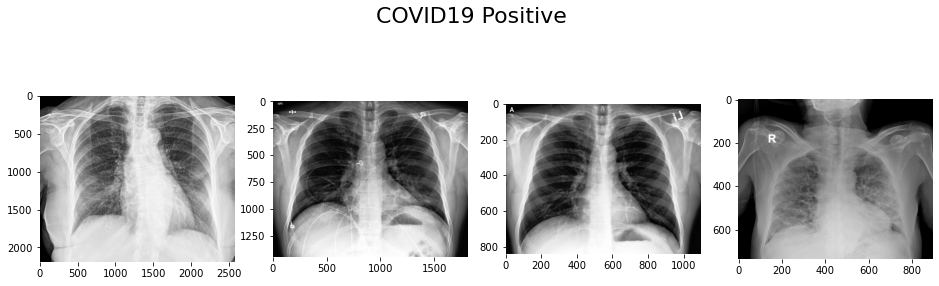

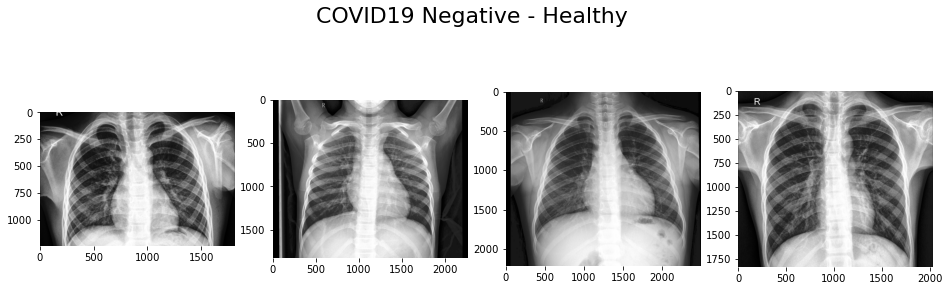

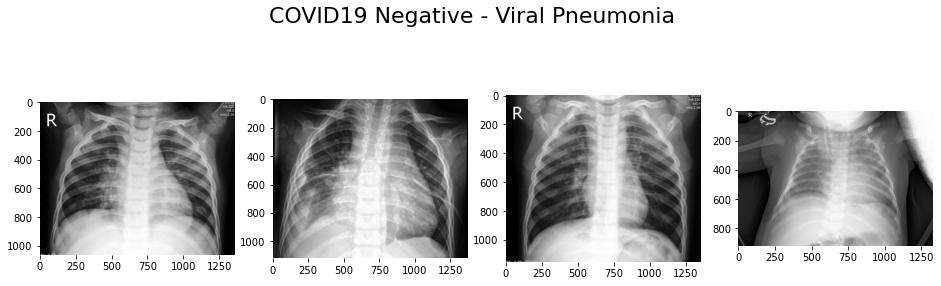

In [9]:
COVID_PATH = DATA_PATH+'/Covid'

fig = plt.figure(figsize=(16,5))
fig.suptitle("COVID19 Positive", size=22)
img_paths = os.listdir(COVID_PATH)
shuffle(img_paths)

for i,image in enumerate(img_paths[:4]):
    img = cv2.imread(os.path.join(COVID_PATH, image))
    plt.subplot(1,4, i+1, frameon=False)
    plt.imshow(img)
fig.show()

NORMAL_PATH = DATA_PATH+'/Normal'

fig = plt.figure(figsize=(16,5))
fig.suptitle("COVID19 Negative - Healthy", size=22)
img_paths = os.listdir(NORMAL_PATH)
shuffle(img_paths)

for i,image in enumerate(img_paths[:4]):
    img = cv2.imread(os.path.join(NORMAL_PATH, image))
    plt.subplot(1,4, i+1, frameon=False)
    plt.imshow(img)
fig.show()

VIRAL_PATH = DATA_PATH+'/Viral Pneumonia'

fig = plt.figure(figsize=(16,5))
fig.suptitle("COVID19 Negative - Viral Pneumonia", size=22)
img_paths = os.listdir(VIRAL_PATH)
shuffle(img_paths)

for i,image in enumerate(img_paths[:4]):
    img = cv2.imread(os.path.join(VIRAL_PATH, image))
    plt.subplot(1,4, i+1, frameon=False)
    plt.imshow(img)
fig.show()

### Using Transforms to build Train/Val/Test Datasets
https://pytorch.org/vision/stable/transforms.html

In [10]:
#Statistics Based on ImageNet Data for Normalisation
mean_nums = [0.485, 0.456, 0.406]
std_nums = [0.229, 0.224, 0.225]


image_transforms = {
    'train': transforms.Compose([
            transforms.Resize((150,150)), #Resizes all images into same dimension
            transforms.RandomRotation(10), # Rotates the images upto Max of 10 Degrees
            transforms.RandomHorizontalFlip(p=0.4), #Performs Horizantal Flip over images 
            transforms.ToTensor(), # Coverts into Tensors
            transforms.Normalize(mean = mean_nums, std=std_nums) # Normalizes
    ]),
    'validation': transforms.Compose([
            transforms.Resize((150,150)),
            transforms.CenterCrop(150), #Performs Crop at Center and resizes it to 150x150
            transforms.ToTensor(),
            transforms.Normalize(mean=mean_nums, std = std_nums)         
    ]),
    'test': transforms.Compose([
            transforms.Resize((150,150)),
            transforms.ToTensor(),
            transforms.Normalize(mean=mean_nums, std = std_nums)               
    ])
}

### Create iterator for the data loader using DataLoader module

In [11]:
batch_size = 10

data = {
    'train': datasets.ImageFolder(root='./sagemaker/DEMO-cv-covid/Covid19-dataset/training/', transform=image_transforms['train']),
    'validation': datasets.ImageFolder(root='./sagemaker/DEMO-cv-covid/Covid19-dataset/validation/',transform=image_transforms['validation']),
    'test': datasets.ImageFolder(root='./sagemaker/DEMO-cv-covid/Covid19-dataset/test/', transform=image_transforms['test'])
}


Create the datsets using loader.DataLoader helper from torch.utils.data. Use the data json object and use the batch_size param and flag shuffle to TRUE. 


In [12]:
train_data = loader.DataLoader(data['train'], batch_size=batch_size, shuffle=True)
validation_data = loader.DataLoader(data['validation'], batch_size=batch_size, shuffle=True)
test_data = loader.DataLoader(data['test'], batch_size=1, shuffle=True)

# Get size of data to be used for calculating loss

train_data_size = len(data['train'])
validation_data_size = len(data['validation'])
test_data_size =  len(data['test'])

In [13]:
train_data_size, validation_data_size, test_data_size

(201, 50, 66)

### PyTorch has device object to load the data into the either of two hardware [CPU or CUDA(GPU)]

In [14]:
if torch.cuda.is_available():
    device=torch.device("cuda:0")
    print("Training on GPU... Ready for HyperJump...")
else:
    device = torch.device("cpu")
    print("Training on CPU... May the force be with you...")

Training on CPU... May the force be with you...


### In this demo, we going to use DenseNet-121 Architecture as the core. We also use Transfer Learning, by set the pre-trained as True.


You may read more about Densenet in this website : https://arxiv.org/abs/1608.06993

In [15]:
def CNN_Model(pretrained=True):
    model = models.densenet121(pretrained=pretrained) # Returns Defined Densenet model with weights trained on ImageNet
    num_ftrs = model.classifier.in_features # Get the number of features output from CNN layer
    model.classifier = nn.Linear(num_ftrs, len(class_names)) # Overwrites the Classifier layer with custom defined layer for transfer learning
    model = model.to(device) # Transfer the Model to GPU if available
    return model

model = CNN_Model(pretrained=True)

# specify loss function (categorical cross-entropy loss)
criterion = nn.CrossEntropyLoss() 

# Specify optimizer which performs Gradient Descent
optimizer = optim.Adam(model.parameters(), lr=1e-3)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1) # Learning Scheduler

In [16]:
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Number of trainable parameters: \n{}".format(pytorch_total_params))

Number of trainable parameters: 
6956931


In [17]:
dataloaders = {"train":train_data, "val":validation_data}
data_sizes = {x: len(dataloaders[x].sampler) for x in ['train','val']}
class_names = train_data.dataset.classes

print(data_sizes)
print(class_names)

{'train': 201, 'val': 50}
['Covid', 'Normal', 'Viral Pneumonia']


### Below is the training model code to run the model training

In [18]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = np.inf

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            current_loss = 0.0
            current_corrects = 0
            current_kappa = 0
            val_kappa = list()

            for inputs, labels in tqdm.tqdm(dataloaders[phase], desc=phase, leave=False):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # We need to zero the gradients in the Cache.
                optimizer.zero_grad()

                # Time to carry out the forward training poss
                # We only need to log the loss stats if we are in training phase
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                if phase == 'train':
                    scheduler.step()

                # We want variables to hold the loss statistics
                current_loss += loss.item() * inputs.size(0)
                current_corrects += torch.sum(preds == labels.data)
                val_kappa.append(cohen_kappa_score(preds.cpu().numpy(), labels.data.cpu().numpy()))
            epoch_loss = current_loss / data_sizes[phase]
            epoch_acc = current_corrects.double() / data_sizes[phase]
            if phase == 'val':
                epoch_kappa = np.mean(val_kappa)
                print('{} Loss: {:.4f} | {} Accuracy: {:.4f} | Kappa Score: {:.4f}'.format(
                    phase, epoch_loss, phase, epoch_acc, epoch_kappa))
            else:
                print('{} Loss: {:.4f} | {} Accuracy: {:.4f}'.format(
                    phase, epoch_loss, phase, epoch_acc))

            # EARLY STOPPING
            if phase == 'val' and epoch_loss < best_loss:
                print('Val loss Decreased from {:.4f} to {:.4f} \nSaving Weights... '.format(best_loss, epoch_loss))
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_since = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_since // 60, time_since % 60))
    print('Best val loss: {:.4f}'.format(best_loss))

    # Now we'll load in the best model weights and return it
    model.load_state_dict(best_model_wts)
    return model

In [19]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_handeled = 0
    ax = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
    
            for j in range(inputs.size()[0]):
                images_handeled += 1    
                ax = plt.subplot(num_images//2, 2, images_handeled)
                ax.axis('off')
                ax.set_title('Actual: {} predicted: {}'.format(class_names[labels[j].item()],class_names[preds[j]]))
                imshow(inputs.cpu().data[j], (5,5))

                if images_handeled == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [20]:

base_model = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=10)

Epoch 1/10
----------


train:   0%|          | 0/21 [00:00<?, ?it/s]

/home/ec2-user/anaconda3/envs/pytorch_latest_p37/lib/python3.7/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


train Loss: 0.5008 | train Accuracy: 0.8060


/home/ec2-user/anaconda3/envs/pytorch_latest_p37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


val:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.3766 | val Accuracy: 0.8800 | Kappa Score: 0.8189
Val loss Decreased from inf to 0.3766 
Saving Weights... 

Epoch 2/10
----------


train:   0%|          | 0/21 [00:00<?, ?it/s]

train Loss: 0.4044 | train Accuracy: 0.8806


val:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.3165 | val Accuracy: 0.9200 | Kappa Score: 0.8745
Val loss Decreased from 0.3766 to 0.3165 
Saving Weights... 

Epoch 3/10
----------


train:   0%|          | 0/21 [00:00<?, ?it/s]

train Loss: 0.3102 | train Accuracy: 0.8955


val:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.2947 | val Accuracy: 0.9200 | Kappa Score: 0.8740
Val loss Decreased from 0.3165 to 0.2947 
Saving Weights... 

Epoch 4/10
----------


train:   0%|          | 0/21 [00:00<?, ?it/s]

train Loss: 0.3718 | train Accuracy: 0.8507


val:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.3259 | val Accuracy: 0.8800 | Kappa Score: 0.7953

Epoch 5/10
----------


train:   0%|          | 0/21 [00:00<?, ?it/s]

train Loss: 0.3920 | train Accuracy: 0.9005


val:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.4212 | val Accuracy: 0.8400 | Kappa Score: 0.7560

Epoch 6/10
----------


train:   0%|          | 0/21 [00:00<?, ?it/s]

train Loss: 0.3767 | train Accuracy: 0.8756


val:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.3099 | val Accuracy: 0.9000 | Kappa Score: 0.8408

Epoch 7/10
----------


train:   0%|          | 0/21 [00:00<?, ?it/s]

train Loss: 0.4211 | train Accuracy: 0.8507


val:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.3481 | val Accuracy: 0.9000 | Kappa Score: 0.8436

Epoch 8/10
----------


train:   0%|          | 0/21 [00:00<?, ?it/s]

train Loss: 0.3862 | train Accuracy: 0.8657


val:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.3877 | val Accuracy: 0.8800 | Kappa Score: 0.8091

Epoch 9/10
----------


train:   0%|          | 0/21 [00:00<?, ?it/s]

train Loss: 0.3749 | train Accuracy: 0.8706


val:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.3145 | val Accuracy: 0.9200 | Kappa Score: 0.8646

Epoch 10/10
----------


train:   0%|          | 0/21 [00:00<?, ?it/s]

train Loss: 0.2917 | train Accuracy: 0.9154


val:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.2946 | val Accuracy: 0.9200 | Kappa Score: 0.8650
Val loss Decreased from 0.2947 to 0.2946 
Saving Weights... 

Training complete in 5m 42s
Best val loss: 0.2946


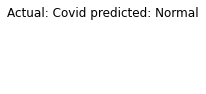

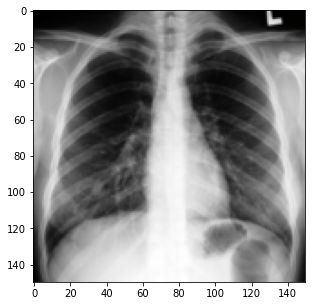

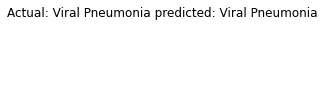

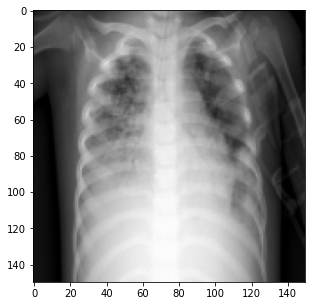

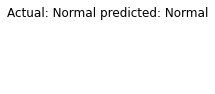

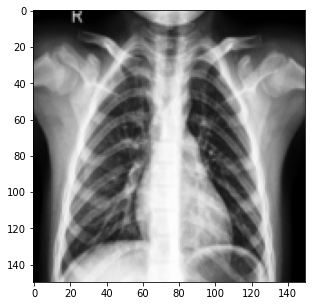

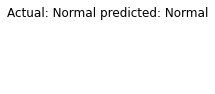

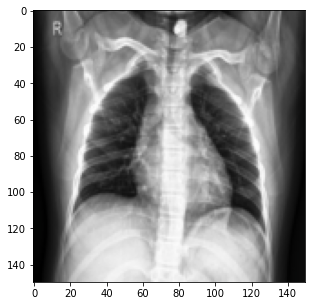

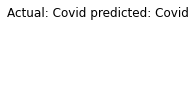

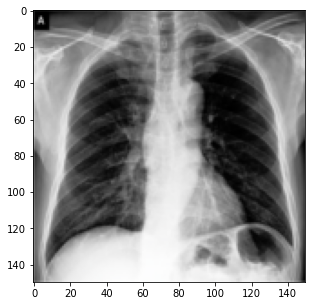

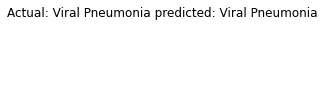

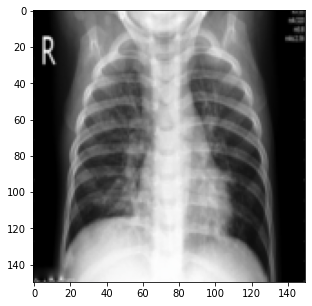

In [21]:
def imshow(inp, size =(30,30), title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = mean_nums
    std = std_nums
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=size)
    plt.imshow(inp)
    if title is not None:
        plt.title(title, size=30)
    plt.pause(0.001)  # pause a bit so that plots are updated


visualize_model(base_model)
plt.show()

### Model Evaluation

In [22]:
y_pred_list = []
y_true_list = []
with torch.no_grad():
    for x_batch, y_batch in tqdm.tqdm(test_data, leave=False):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        y_test_pred = base_model(x_batch)
        y_test_pred = torch.log_softmax(y_test_pred, dim=1)
        _, y_pred_tag = torch.max(y_test_pred, dim = 1)
        y_pred_list.append(y_pred_tag.cpu().numpy())
        y_true_list.append(y_batch.cpu().numpy())

  0%|          | 0/66 [00:00<?, ?it/s]

In [23]:
y_pred_list = [i[0] for i in y_pred_list]
y_true_list = [i[0] for i in y_true_list]

In [24]:
print(classification_report(y_true_list, y_pred_list))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        26
           1       1.00      0.75      0.86        20
           2       0.80      1.00      0.89        20

    accuracy                           0.92        66
   macro avg       0.93      0.92      0.92        66
weighted avg       0.94      0.92      0.92        66



In [25]:

def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

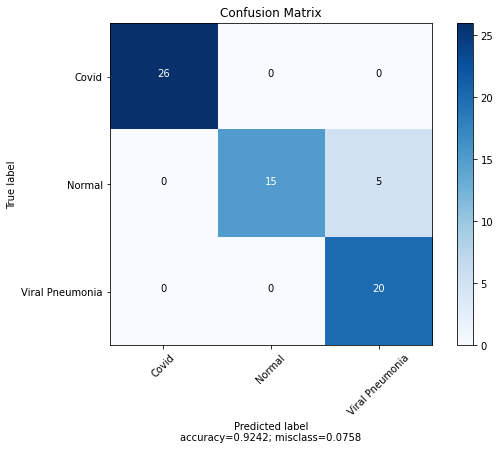

In [26]:


cm =  confusion_matrix(y_true_list, y_pred_list)

plot_confusion_matrix(cm = cm, 
                      normalize    = False,
                      target_names = ['Covid', 'Normal', 'Viral Pneumonia'],
                      title        = "Confusion Matrix")

In [27]:
torch.save(base_model.state_dict(), './best_model.pth')

### Build the prediction method

In [28]:
def predictPath(model, path):
    image = Image.open(path)
    transform = image_transforms['test']
    image_tensor = transform(image)
    image_tensor = image_tensor.unsqueeze_(0)
    input = Variable(image_tensor)
    # print(input.shape)
    input = input.to(torch.device('cpu'))
    out = model(input)
    _, preds = torch.max(out, 1)
    idx = preds.cpu().numpy()[0]
    pred_class = class_names[idx]
    score = out[0][0].item()
    plt.imshow(np.array(image))
    print("Predicted: {}".format(pred_class))
    probabilities = torch.nn.functional.softmax(out[0], dim=0)
    top3_prob, top3_catid = torch.topk(probabilities, 3)
    for i in range(top3_prob.size(0)):
        print(class_names[top3_catid[i]], top3_prob[i].item())

In [29]:


def predictUrl(model, url):
    image = Image.open(requests.get(url, stream=True).raw)
    transform = image_transforms['test']
    image_tensor = transform(image)
    image_tensor = image_tensor.unsqueeze_(0)
    input = Variable(image_tensor)
    # print(input.shape)
    input = input.to(torch.device('cpu'))
    out = model(input)
    _, preds = torch.max(out, 1)
    idx = preds.cpu().numpy()[0]
    pred_class = class_names[idx]
    score = out[0][0].item()
    plt.imshow(np.array(image))
    probabilities = torch.nn.functional.softmax(out[0], dim=0)
    top3_prob, top3_catid = torch.topk(probabilities, 3)
    for i in range(top3_prob.size(0)):
        print(class_names[top3_catid[i]], top3_prob[i].item())

### Predict with those URL's

Google for image urls!

Covid 0.949996829032898
Normal 0.049279484897851944
Viral Pneumonia 0.0007236094097606838


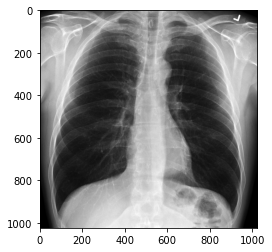

In [30]:
################################################################
############ To do: make prediction ######
################################################################
# makePrediction(<insert your params here>)
predictUrl(base_model,'https://prod-images-static.radiopaedia.org/images/220869/76052f7902246ff862f52f5d3cd9cd_jumbo.jpg')



Covid 0.9999548196792603
Viral Pneumonia 2.9388858820311725e-05
Normal 1.5741572497063316e-05


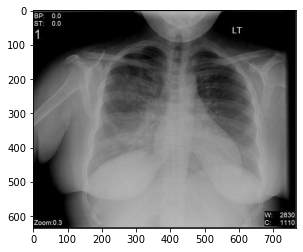

In [31]:
predictUrl(base_model,'https://img.medscapestatic.com/pi/meds/ckb/94/38694.jpg')

Covid 0.9999650716781616
Normal 1.930579855979886e-05
Viral Pneumonia 1.557878204039298e-05


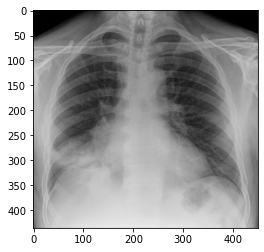

In [32]:
predictUrl(base_model,'https://www.radiologymasterclass.co.uk/images/quizzes/Quiz-Images-Chest-2/question_01.jpg')

Predicted: Normal
Normal 0.5103058815002441
Viral Pneumonia 0.487631618976593
Covid 0.002062516286969185


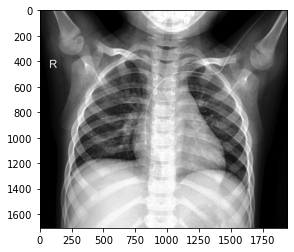

In [33]:
predictPath(base_model, "./sagemaker/DEMO-cv-covid/Covid19-dataset/validation/Normal/01.jpeg")

Predicted: Normal
Normal 0.9951930046081543
Viral Pneumonia 0.0024409356992691755
Covid 0.0023661383893340826


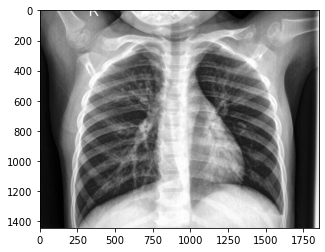

In [34]:
predictPath(base_model, "./sagemaker/DEMO-cv-covid/Covid19-dataset/validation/Normal/063.jpeg")

### Save your model

In [35]:
!tar -czf model.tar.gz model_0.pth
